# Preprocess
This notebook performs pre-processing on the NYTimes dataset (downloaded from [this Kaggle link](https://www.kaggle.com/nzalake52/new-york-times-articles)). Since the data is a raw text file, we need to output it to a tabular format, such as CSV. 

The kind of pre-processing that would be done is specific to the source of the news data, so this notebook is specific to only this NY Times news article dataset. 

In [1]:
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
rc_fonts = {'figure.figsize': (15, 8),
            'axes.labelsize': 18,
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 16}
plt.rcParams.update(rc_fonts)
plt.style.use('ggplot')
%matplotlib inline

### Specify path to raw data in nytimes.txt

In [2]:
data_path = "../data/nytimes.txt"

In [3]:
# Read data for checking
c = 0
with open(data_path, 'r') as file:
    for line in file:
        c += 1
        print(line.strip())
        if c == 30: break        

URL: http://www.nytimes.com/2016/06/30/sports/baseball/washington-nationals-max-scherzer-baffles-mets-completing-a-sweep.html

WASHINGTON — Stellar pitching kept the Mets afloat in the first half of last season despite their offensive woes. But they cannot produce an encore of their pennant-winning season if their lineup keeps floundering while their pitching is nicked, bruised and stretched thin.
“We were going to ride our pitching,” Manager Terry Collins said before Wednesday’s game. “But we’re not riding it right now. We’ve got as many problems with our pitching as we do anything.”
Wednesday’s 4-2 loss to the Washington Nationals was cruel for the already-limping Mets. Pitching in Steven Matz’s place, the spot starter Logan Verrett allowed two runs over five innings. But even that was too large a deficit for the Mets’ lineup to overcome against Max Scherzer, the Nationals’ starter.
“We’re not even giving ourselves chances,” Collins said, adding later, “We just can’t give our pitcher

### Extract article blocks and store them in a Pandas DataFrame

In [4]:
flag = False
urls, content = [], []
with open(data_path, 'r') as file:
    for line in file:
        if flag:
            if line.startswith('URL: '):
                flag = False
                content.append(a)
                a = []
            else:
                if line.strip():
                    a.append(line.strip())       
        if line.startswith('URL: '):
            a = []
            flag = True
            urls.append(line.strip().replace("URL: ", ""))
       
del urls[-1]   # Can't match last block of text for now
print(len(urls))
print(len(content))
df = pd.DataFrame({'url': urls, 'content': content})
df['content'] = df['content'].str.join(' ')

8887
8887


In [5]:
df.tail()

,url,content
8882,http://www.nytimes.com/2016/04/18/nyregion/man...,New York City officers shot and killed a 32-ye...
8883,http://www.nytimes.com/2016/04/18/us/politics/...,There is a second critical contest in America’...
8884,http://www.nytimes.com/2016/04/18/nyregion/he-...,"On April 1, police officers from the 108th Pre..."
8885,http://www.nytimes.com/2016/04/18/world/asia/f...,"KHILAD, India — The cattle camp, on a dusty ba..."
8886,http://www.nytimes.com/2016/04/18/movies/jj-ab...,The director J.J. Abrams dropped a possible hi...


### Parse the URL fields and extract publication dates

In [6]:
s = []
for values in df['url']:
    s.append(re.search(r'[0-9]+/[0-9]+/[0-9]+', values).group())

df['date'] = pd.to_datetime(pd.Series(s), format='%Y/%m/%d')
df = df[['date', 'url', 'content']]
df.head()

,date,url,content
0,2016-06-30,http://www.nytimes.com/2016/06/30/sports/baseb...,WASHINGTON — Stellar pitching kept the Mets af...
1,2016-06-30,http://www.nytimes.com/2016/06/30/nyregion/may...,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,http://www.nytimes.com/2016/06/30/nyregion/thr...,In the early morning hours of Labor Day last y...
3,2016-06-30,http://www.nytimes.com/2016/06/30/nyregion/tek...,It was the Apple Store in New York City before...
4,2016-06-30,http://www.nytimes.com/2016/06/30/sports/olymp...,OMAHA — The United States Olympic swimming tri...


### What date range are the articles in the dataset from?

In [7]:
df['date'].min()

Timestamp('2016-02-24 00:00:00')

In [8]:
df['date'].max()

Timestamp('2016-06-30 00:00:00')

The articles are all from the date range February - June 2016.

### Obtain headline and news-category information from the URL
Ideally, we would scrape the headline directly from the source, but in this specific dataset, the headlines are embedded into the URL. These are extracted accordingly.

In [9]:
# Get only the headline and news_category
href = "http://www.nytimes.com/2016/06/30/world/middleeast/turkey-a-conduit-for-fighters-joining-isis-begins-to-feel-its-wrath.html"
href_split = re.split(r'[0-9]+/[0-9]+/[0-9]+', href)[-1]
print(href_split.split('.'))

['/world/middleeast/turkey-a-conduit-for-fighters-joining-isis-begins-to-feel-its-wrath', 'html']


In [10]:
# Store news-category
news_category = "-".join(i for i in href_split.split('/')[:-1]).strip('-')
print(news_category)
headline = href_split.split('/')[-1].replace("-", " ").replace(".html", "")
print(headline)

world-middleeast
turkey a conduit for fighters joining isis begins to feel its wrath


#### Include the news-category and true-cased headline in our tabular data

In [11]:
# Create DataFrame columns for headline and topic 
news_category, headline = [], []
for row in df['url']:
    href_split = re.split(r'[0-9]+/[0-9]+/[0-9]+', row)[-1]
    news_category.append("-".join(i for i in href_split.split('/')[:-1]).strip('-'))
    not_truecased_h = href_split.split('/')[-1].replace(".html", "").replace("-", " ")
    headline.append(not_truecased_h)
    
df['news_category'] = news_category
df['headline'] = headline
df = df[['date', 'news_category', 'headline', 'content', 'url']]
df.tail()

,date,news_category,headline,content,url
8882,2016-04-18,nyregion,man killed in police shooting in queens author...,New York City officers shot and killed a 32-ye...,http://www.nytimes.com/2016/04/18/nyregion/man...
8883,2016-04-18,us-politics,battle for senate,There is a second critical contest in America’...,http://www.nytimes.com/2016/04/18/us/politics/...
8884,2016-04-18,nyregion,he said his car had been stolen the police say...,"On April 1, police officers from the 108th Pre...",http://www.nytimes.com/2016/04/18/nyregion/he-...
8885,2016-04-18,world-asia,farmers in arid india share camps with their c...,"KHILAD, India — The cattle camp, on a dusty ba...",http://www.nytimes.com/2016/04/18/world/asia/f...
8886,2016-04-18,movies,jj abrams hints reys father is not who you tho...,The director J.J. Abrams dropped a possible hi...,http://www.nytimes.com/2016/04/18/movies/jj-ab...


The headlines extracted are still nowhere near perfect, but this is enough for the purposes of this exercise. Obtaining proper headlines is a case that can be tackled upstream, during data collection (from a reliable source such as [newsapi.org](https://newsapi.org/)).

#### Study the distribution of articles in the dataset

In [12]:
print('The preprocessed data has {} news articles from {} unique topics'\
      .format(df.shape[0], df['news_category'].nunique()))

The preprocessed data has 8887 news articles from 82 unique topics


In [13]:
df['news_category'].value_counts().head()

nyregion             663
us-politics          608
us                   589
business-dealbook    382
world-europe         358
Name: news_category, dtype: int64

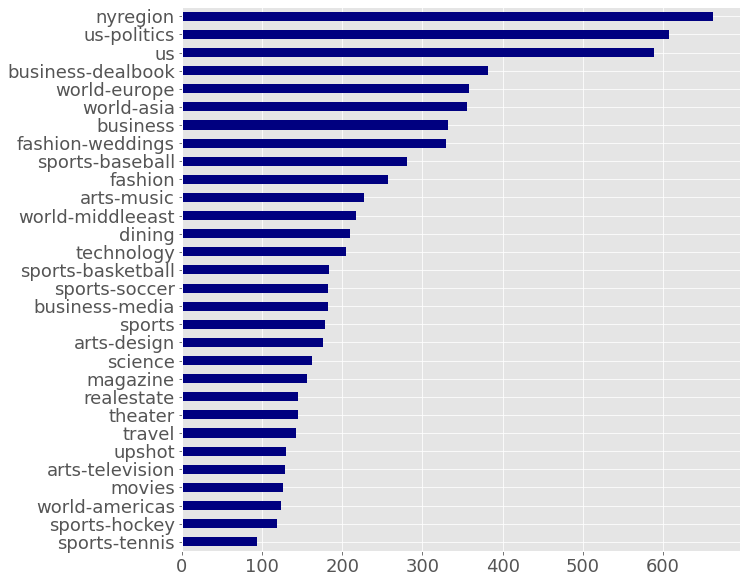

In [14]:
c_topics = df['news_category'].value_counts().to_frame()[:30]
c_topics.sort_values(by='news_category', ascending=True).plot(kind = 'barh', colormap='jet', legend=False, figsize=(10, 10));

#### Check `news_category` counts in the first 2000 articles

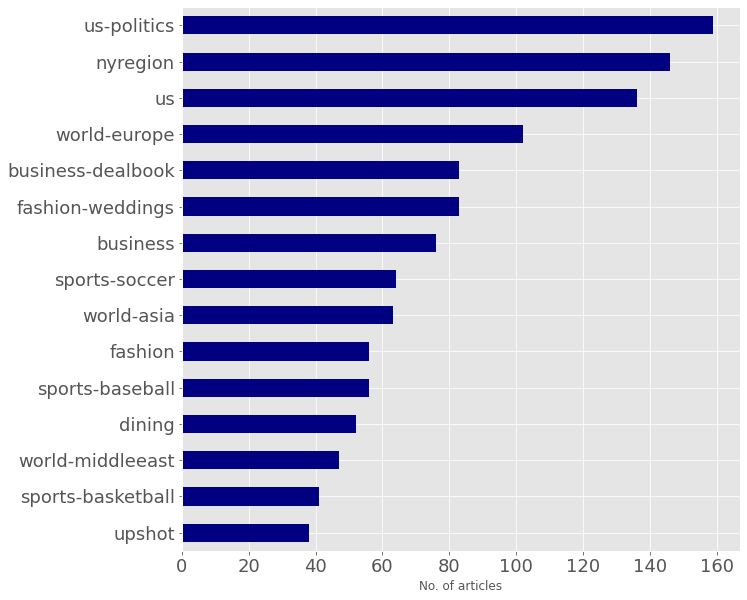

In [15]:
top_2000_topics =  df.loc[:2000, ('news_category')].value_counts().to_frame()[:15]
top_2000_topics.sort_values(by='news_category', ascending=True).plot(kind='barh', colormap='jet', legend=False, figsize=(10, 10));

plt.xlabel('No. of articles');

#### Clean up article text

We first remove the location specification at the start of each article (e.g. "WASHINGTON — ")

In [16]:
pattern = re.compile(r'^\b[A-Z\s]+[\,\.]*[A-Za-z\s\,\.]+—')

def clean_article_start(text):
#     text = pattern.sub('', text)
    matched = pattern.findall(text)
    if matched:
        text = text[len(matched[0]):]
    return text.strip()

#### Remove items with Chinese, Japanese or Korean characters

In [17]:
def cjk_detect(texts):
    # korean
    if re.search("[\uac00-\ud7a3]", texts):
        return False
    # japanese
    if re.search("[\u3040-\u30ff]", texts):
        return False
    # chinese
    if re.search("[\u4e00-\u9FFF]", texts):
        return False
    return True

#### Remove articles that are purely lists for subscribing to other articles
Sometimes we have articles that aren't really articles at all, but are sign-up lists for news briefings via email. These start with a common pattern, which can be identified and removed.

In [18]:
def remove_subscribe_list(text):
    subs_string = 'Want to get this briefing by email? Here’s the sign-up.'
    if subs_string in text:
        text = ''
    return text

#### Remove underscore "clumps"
A fea articles have chained underscores that do not add any meaning to the text - these are cleaned and removed.

In [19]:
def remove_underscores(text):
    text = re.sub(r'_?', '', text)
    return text

### Run cleanup utilities on the data
In this section, we run the Chinese article, subscription-list and underscore cleaning utilities on the dataset

In [20]:
# pip install tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

df['is_english'] = df['content'].apply(cjk_detect)
df = df[df['is_english'] == True]

# Clean unwanted stuff
df['content_new'] = df['content'].progress_apply(clean_article_start)
df['content_new'] = df['content_new'].progress_apply(remove_subscribe_list)
df['content_new'] = df['content_new'].progress_apply(remove_underscores)

In [21]:
df.head()

,date,news_category,headline,content,url,is_english,content_new
0,2016-06-30,sports-baseball,washington nationals max scherzer baffles mets...,WASHINGTON — Stellar pitching kept the Mets af...,http://www.nytimes.com/2016/06/30/sports/baseb...,True,Stellar pitching kept the Mets afloat in the f...
1,2016-06-30,nyregion,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,http://www.nytimes.com/2016/06/30/nyregion/may...,True,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,nyregion,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,http://www.nytimes.com/2016/06/30/nyregion/thr...,True,In the early morning hours of Labor Day last y...
3,2016-06-30,nyregion,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...,http://www.nytimes.com/2016/06/30/nyregion/tek...,True,It was the Apple Store in New York City before...
4,2016-06-30,sports-olympics,once at michael phelpss feet and still chasing...,OMAHA — The United States Olympic swimming tri...,http://www.nytimes.com/2016/06/30/sports/olymp...,True,The United States Olympic swimming trials are ...


### Output tabular data to file
The structured and preprocessed NYT dataset is now output to file.

In [22]:
write_df = df[['date', 'headline', 'content_new']].reindex()
write_df = write_df[write_df['content_new'] != '']
# write_df.to_csv("./nytimes.tsv", sep='\t', header=None, index=False)